# Socio-Economic Factors

A large part of the character of a city’s people can be understood by looking at socio-economic and health indices. These make us privy to quality of life indicators such as education levels, fertility rates and household sizes, sex ratio, and employment types.

### 2011 Primary Census Abstract for Pune

In India, the census is conducted every 10 years, starting from 1872 (regularly since 1881).
It collects data on various indicators on:
1. Household Level: Housing quality & material, number of rooms, ownership status
1. Individual Level: Age, gender, literacy, caste, economic activity, etc.


The census also provides separate data for Scheduled Castes (SC) and Scheduled Tribes (ST), and ‘others’ i.e. not belonging to either the first two categories.

The Primary Census Abstract gives an overview of these various variables at the Ward level, which we will be using in our research.



In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

np.random.seed(0)
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
pnq_full = pd.read_csv("data/PCA_pune_2011.csv")
pnq_full = pnq_full.sort_values('Ward')
pnq_full.tail()

,Ward,No_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,P_SC,M_SC,...,MARG_AL_0_3_F,MARG_HH_0_3_P,MARG_HH_0_3_M,MARG_HH_0_3_F,MARG_OT_0_3_P,MARG_OT_0_3_M,MARG_OT_0_3_F,NON_WORK_P,NON_WORK_M,NON_WORK_F
139,140,10236,45476,24182,21294,6911,3580,3331,7231,3718,...,0,15,3,12,139,71,68,29388,11097,18291
140,141,9712,41214,21539,19675,5514,2922,2592,4722,2442,...,0,4,1,3,38,18,20,26462,9529,16933
141,142,4113,17067,8821,8246,1806,963,843,1341,663,...,0,4,3,1,12,7,5,10884,3995,6889
142,143,10168,40938,21214,19724,4343,2306,2037,2561,1305,...,0,8,2,6,70,46,24,26773,10384,16389
143,144,6307,26762,14135,12627,3742,2028,1714,2619,1342,...,0,30,16,14,49,35,14,16829,6035,10794


The PCA loaded above does not have the geometry column, which we will attach from a shapefile.

In [3]:
pnq_census = gpd.read_file("data/pune_census_wards_2011_shp/pune_census_wards_2011.shp")
pnq_census = gpd.GeoDataFrame(pnq_census)
pnq_census.rename(columns={'ward_no': 'Ward'}, inplace=True)
pnq_census = pnq_census.sort_values('Ward')
pnq_census.tail()

,_06_pop,area,_06_f,sc_f,st_f,_06_m,sc_m,st_m,households,cartodb_id,...,tot_densit,sc_density,st_density,tot_f,tot_m,tot_pop,Ward,id,name,geometry
129,6911,6308901,3331,3513,319,3580,3718,351,10236,129,...,7208,1146,106,21294,24182,45476,140,140,Kondhwa (Budruk),"POLYGON ((73.88081099999998 18.44186899999998,..."
90,5514,4354855,2592,2280,492,2922,2442,472,9712,88,...,9464,1084,221,19675,21539,41214,141,141,Katraj Gaon,"POLYGON ((73.88081099999998 18.44186899999998,..."
91,1806,1169192,843,678,54,963,663,55,4113,91,...,14597,1147,93,8246,8821,17067,142,142,Rajiv Gandhi Zoo,"POLYGON ((73.86250199999999 18.463727, 73.8626..."
94,4343,2175228,2037,1256,222,2306,1305,213,10168,94,...,18820,1177,200,19724,21214,40938,143,143,Bharti Vidyapeeth,"POLYGON ((73.83876099999999 18.45391199999998,..."
102,3742,3175132,1714,1277,178,2028,1342,197,6307,103,...,8429,825,118,12627,14135,26762,144,144,Agam Mandir Katraj,"POLYGON ((73.84190634077623 18.45300478417375,..."


Joining the geometry column of the geopandas to the previous complete table.

In [4]:
pnq_full['name'] = pnq_census['name']

In [5]:
pnq_full['area'] = pnq_census['area']

In [6]:
pnq_full['geometry'] = pnq_census['geometry']
pnq_full = gpd.GeoDataFrame(pnq_full)

We now save this common file for future uses.

In [7]:
gpd.GeoDataFrame.to_file(pnq_full, 'data/PCA_complete')

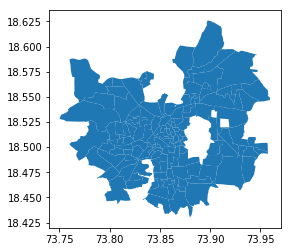

In [8]:
pnq_full.plot()

We see all the 144 census wards mapped above. The three islands observed are the Pune Cantonment Board (PCB), and two of its exclave properties. The PCB is governed separately by the Defense Ministry, and the Pune Municipal Corporation does not have jurisdiction over it.

### Demographic Minorities: Scheduled Castes and Scheduled Tribes

Scheduled Castes and Scheduled Tribes are social classifications, made for administrative purposes, made to group underprivileged communities for a wide variety of affirmative action programs and HDI improvement schemes.

These groups are generally considered minorities, and are such in Pune. 

It would be interesting to see how their proportions are manifested by census wards in Pune.

We proceed to classify a ward as either majority dominant, or majority non-dominant. We consider a ward to be majority dominant if the proportion of SC-ST population is below the overall median+IQR value for the entire city.

In [9]:
pnq_full['pct_scst'] = ((pnq_full['P_SC'] + pnq_full['P_ST']) / pnq_full['TOT_P'])*100
pnq_full['pct_scst'].describe()

count    144.000000
mean      14.927493
std       10.188836
min        0.868307
25%        7.721396
50%       12.618573
75%       19.980411
max       53.134126
Name: pct_scst, dtype: float64

In [10]:
np.subtract(*np.percentile(pnq_full['pct_scst'], [75, 25]))

12.25901507865425

Text(0.5, 1.0, 'Census Wards with Proportion of SC/ST Population')

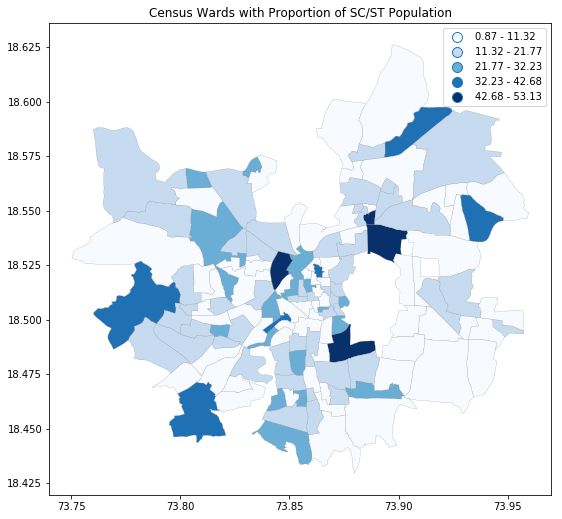

In [11]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = pnq_full.plot(ax=ax, 
                     column='pct_scst', 
                     cmap='Blues', 
                     edgecolor='grey', 
                     lw=0.2, 
                 scheme = 'equal_interval',
                     k = 5,
                    legend = True,)
ax.set_title('Census Wards with Proportion of SC/ST Population')

We create a new column corresponding to whether the census ward is majority dominant or minority dominant.

In [12]:
pnq_full['dom'] = np.where(pnq_full['pct_scst']>=24.87758807865425, 'Minority', 'Majority')

Text(0.5, 1.0, 'Census Wards: Minority or Majority Dominant')

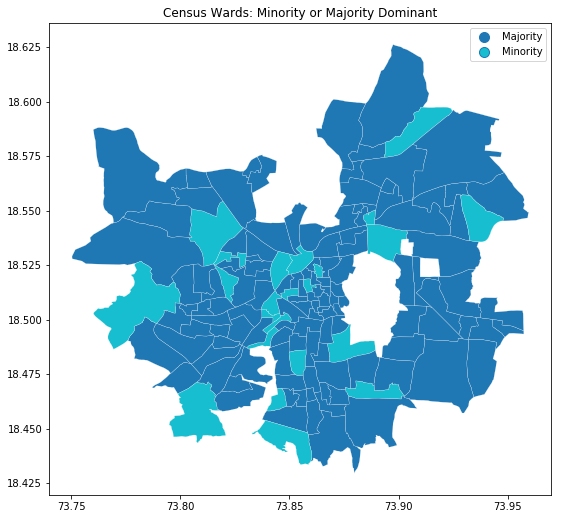

In [13]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = pnq_full.plot(ax=ax, 
                     column='dom', 
                     cmap='tab10', 
                     edgecolor='white', 
                     lw=0.2,
                    legend = True,)
ax.set_title('Census Wards: Minority or Majority Dominant')

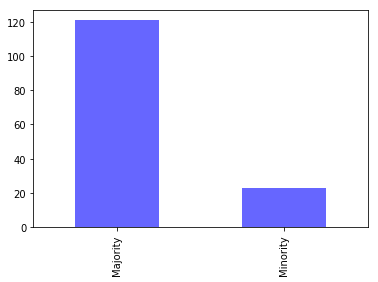

In [14]:
domward = pnq_full['dom'].value_counts()
domward
domward.plot(kind='bar',
                     color = 'blue',
                     alpha = .6)

It would be interesting to see how the rate of literacy can affect or is affected by population of Scheduled Castes and Scheduled Tribes within a ward. Historically these groups were denied access to education, and even today their rates of literacy remain low.

In [15]:
list(pnq_full)

['Ward',
 'No_HH',
 'TOT_P',
 'TOT_M',
 'TOT_F',
 'P_06',
 'M_06',
 'F_06',
 'P_SC',
 'M_SC',
 'F_SC',
 'P_ST',
 'M_ST',
 'F_ST',
 'P_LIT',
 'M_LIT',
 'F_LIT',
 'P_ILL',
 'M_ILL',
 'F_ILL',
 'TOT_WORK_P',
 'TOT_WORK_M',
 'TOT_WORK_F',
 'MAINWORK_P',
 'MAINWORK_M',
 'MAINWORK_F',
 'MAIN_CL_P',
 'MAIN_CL_M',
 'MAIN_CL_F',
 'MAIN_AL_P',
 'MAIN_AL_M',
 'MAIN_AL_F',
 'MAIN_HH_P',
 'MAIN_HH_M',
 'MAIN_HH_F',
 'MAIN_OT_P',
 'MAIN_OT_M',
 'MAIN_OT_F',
 'MARGWORK_P',
 'MARGWORK_M',
 'MARGWORK_F',
 'MARG_CL_P',
 'MARG_CL_M',
 'MARG_CL_F',
 'MARG_AL_P',
 'MARG_AL_M',
 'MARG_AL_F',
 'MARG_HH_P',
 'MARG_HH_M',
 'MARG_HH_F',
 'MARG_OT_P',
 'MARG_OT_M',
 'MARG_OT_F',
 'MARGWORK_3_6_P',
 'MARGWORK_3_6_M',
 'MARGWORK_3_6_F',
 'MARG_CL_3_6_P',
 'MARG_CL_3_6_M',
 'MARG_CL_3_6_F',
 'MARG_AL_3_6_P',
 'MARG_AL_3_6_M',
 'MARG_AL_3_6_F',
 'MARG_HH_3_6_P',
 'MARG_HH_3_6_M',
 'MARG_HH_3_6_F',
 'MARG_OT_3_6_P',
 'MARG_OT_3_6_M',
 'MARG_OT_3_6_F',
 'MARGWORK_0_3_P',
 'MARGWORK_0_3_M',
 'MARGWORK_0_3_F',
 'MARG_CL

In [16]:
pnq_full['pct_lit'] = (pnq_full['P_LIT'] / pnq_full['TOT_P']) * 100

pnq_full.head()

,Ward,No_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,P_SC,M_SC,...,MARG_OT_0_3_F,NON_WORK_P,NON_WORK_M,NON_WORK_F,name,area,geometry,pct_scst,dom,pct_lit
0,1,10452,44060,23099,20961,5686,2993,2693,8216,4202,...,44,27709,10171,17538,Lohiyanagar,123695,"POLYGON ((73.86329999999998 18.50339199999998,...",22.167499,Majority,79.280527
1,2,5933,25430,13125,12305,3054,1591,1463,3887,1985,...,156,15665,6183,9482,Gurunanak Nagar,220372,"POLYGON ((73.87355099999998 18.50539199999999,...",16.268187,Majority,77.361384
2,3,5487,22592,11528,11064,2487,1347,1140,4846,2444,...,17,13974,5249,8725,Chaitanyanagar Dhankavadi,466470,"POLYGON ((73.85167599999997 18.46751599999998,...",22.543378,Majority,78.886331
3,4,5906,24678,12830,11848,2586,1367,1219,3478,1744,...,26,15244,5763,9481,Satavwadi,685793,"POLYGON ((73.95740699999999 18.49487099999997,...",16.176351,Majority,82.956479
4,5,4242,18490,9378,9112,1972,1023,949,5611,2801,...,30,11505,4377,7128,Dandekar Pul - Dattawadi,298112,"POLYGON ((73.84239199999999 18.49872899999999,...",31.681990,Minority,77.517577


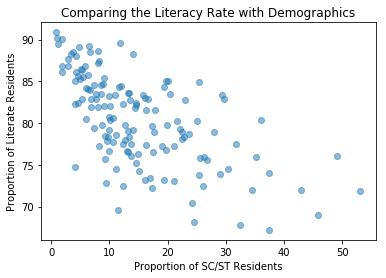

In [17]:
plt.scatter(y = pnq_full['pct_lit'],
            x = pnq_full['pct_scst'],
            alpha=0.5)
plt.title('Comparing the Literacy Rate with Demographics')
plt.xlabel('Proportion of SC/ST Residents')
plt.ylabel('Proportion of Literate Residents')
plt.show()

### Proportion of Marginal Workers to Full Time Workers

In [18]:
pnq_full['pct_marg'] = (pnq_full['MARGWORK_P']/pnq_full['TOT_WORK_P'])*100

In [19]:
var = 'pct_marg'

In [20]:
# create two data subsets
min_wards = pnq_full[pnq_full['pct_scst'] >= 24.87758807865425]
mingrp = min_wards[var]
maj_wards = pnq_full[pnq_full['pct_scst'] < 24.87758807865425]
majgrp = maj_wards[var]

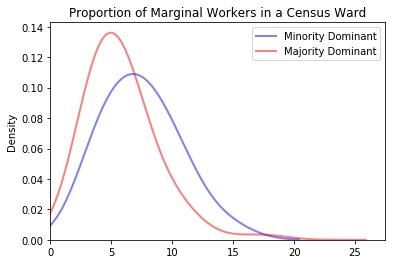

In [21]:
# what are the probability distributions of these two data sets?
fig, ax = plt.subplots()
ax = mingrp.plot.kde(ls='-', c='blue', alpha=0.5, lw=2, bw_method=0.7, label = 'Minority Dominant')
ax = majgrp.plot.kde(ls='-', c='red', alpha=0.5, lw=2, bw_method=0.7, ax=ax, label = 'Majority Dominant')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.title('Proportion of Marginal Workers in a Census Ward')
plt.ylabel('Density')
ax.legend()
plt.show()

In [22]:
print(int(mingrp.mean()))
print(int(majgrp.mean()))

7
5


In [23]:
t_statistic, p_value = stats.ttest_ind(mingrp, majgrp, equal_var=False, nan_policy='omit')
p_value

0.024335084727439508

In [24]:
alpha = 0.05
p_value < alpha

True

We see that the difference in means is statistically significant. A larger than regular proportion of SC/ST population does indicate a larger percentage of population engaged in marginal work.

In [25]:
gpd.GeoDataFrame.to_file(pnq_full, 'data/PCA_complete')